# 2. Training phase: Coresponds to loading data and performing various regression techniques inorder to make prediction.

In [3]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import functions as F

from pyspark.ml.feature import RFormula
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import PCA
from pyspark.ml import Pipeline 

from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import AFTSurvivalRegression
from pyspark.ml.regression import IsotonicRegression
#from pyspark.ml.regression import FMRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt




In [2]:
!pip install numpy

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable


#### step 1: Features include settings and the features extracted from the dataset. Definining this list will help in step 3 for setting up RFormula.
#### [CNC_id] and [cycle] are not part of training. They will be used to notify with alert in the real time inference phase to identify the CNC machine and the coresponding cycle.

In [4]:
features = ['voltage','current','contact_force','angular_velocity','linear_velocity','cutter_position','F1','F2','beta']
settings = ['mass','resistance','radius','torque_const','voltage_const','censor']
features.extend(settings)

#### step 2: initialize the spark context

In [5]:
sc = SparkContext.getOrCreate()
sqlContext = SQLContext.getOrCreate(sc)

# Step 3: Load the train set
#### from the same repository used to store train_df in the data preparation phase
#### droping _c0 would remove the index column if exists (not used for training)

In [6]:
df_train = spark.read.format("csv")\
    .option("delimiter", ",")\
    .option("header", "True")\
    .load('/tmp/morepro/data/train_df.csv',inferSchema= True)\
    .drop('_c0')
# print(df_train.show(5))
# print(df_train.printSchema())

#### We can visulize the train set as follows

In [7]:
df_train.show(5)

+------------------+------------------+-------------+----------------+---------------+---------------+---+---+----+------+-----+----+----------+------+------------+-------------+------+-----+
|           voltage|           current|contact_force|angular_velocity|linear_velocity|cutter_position| F1| F2|beta|CNC_id|cycle|mass|resistance|radius|torque_const|voltage_const|censor|  rul|
+------------------+------------------+-------------+----------------+---------------+---------------+---+---+----+------+-----+----+----------+------+------------+-------------+------+-----+
|14.018901483057599|               0.0|            0|             0.1|            0.0|            0.0|0.0|3.0| 0.1|     1|    0| 3.0|       0.6|   0.3|         1.5|          0.2|     1|100.0|
|32.717150504498804|17.891433157638897|            0|8.75278527186944|            0.0|            0.0|0.0|3.0| 0.1|     1|    1| 3.0|       0.6|   0.3|         1.5|          0.2|     1|100.0|
|48.589192507190894|  37.9114982198866| 

# Step 4: Configure preprcoessing pipeline stages
#### primary stage is to make a single column out of all the available features. This is required for the training in the spark framework.
#### Secondly we would apply min-max scaler as feature scaling.
#### PCA could also be used but the results were not so promising. We can choose to skip it for now as the algorithms seem to already have low latency even with the given dimensions of the feature space

In [8]:
r_formula = 'rul ~ ' + '+'.join(features)
formula = RFormula(formula=r_formula)
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
#pca = PCA(k=3, inputCol="scaledFeatures",outputCol="pcaFeatures")


# Build the pipeline 
pipeline = Pipeline(stages=[formula, scaler]) #pca
# Fit the pipeline 
pipeline_model = pipeline.fit(df_train) 
# Make a prediction 
transformedData = pipeline_model.transform(df_train)

#### After applying the pipeline stages we get additional columns: 
#### features corresponding to RFormula, 
#### scaledFeatures applying min-max scaler, 
#### label is similar to rul

In [9]:
transformedData.show(5)

+------------------+------------------+-------------+----------------+---------------+---------------+---+---+----+------+-----+----+----------+------+------------+-------------+------+-----+--------------------+-----+--------------------+
|           voltage|           current|contact_force|angular_velocity|linear_velocity|cutter_position| F1| F2|beta|CNC_id|cycle|mass|resistance|radius|torque_const|voltage_const|censor|  rul|            features|label|      scaledFeatures|
+------------------+------------------+-------------+----------------+---------------+---------------+---+---+----+------+-----+----+----------+------+------------+-------------+------+-----+--------------------+-----+--------------------+
|14.018901483057599|               0.0|            0|             0.1|            0.0|            0.0|0.0|3.0| 0.1|     1|    0| 3.0|       0.6|   0.3|         1.5|          0.2|     1|100.0|[14.0189014830575...|100.0|[0.0,0.0,0.0,0.0,...|
|32.717150504498804|17.891433157638897| 

# * Model Training *

# Linear Regression

In [9]:
lr = LinearRegression(featuresCol = 'scaledFeatures', labelCol='label', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(transformedData)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

lr_pred = lr_model.transform(transformedData)

Coefficients: [0.0,1.462263132548203,0.0,0.0,0.0,0.0,0.0,-4.614481661105409,-74.05474776796159,3.1163971783237594,-1.895354935249919,-5.6414900874768215,-0.9345296929216205,4.973269266589901,0.0]
Intercept: 102.45298394216887


# Decision Tree Regressor

In [129]:
dt = DecisionTreeRegressor(featuresCol ='scaledFeatures', labelCol = 'label')
dt_model = dt.fit(transformedData)
dt_pred = dt_model.transform(transformedData)

# Gradient Boosting Tree Regressor

In [130]:
gbt = GBTRegressor(featuresCol = 'scaledFeatures', labelCol = 'label', maxIter=10)
gbt_model = gbt.fit(transformedData)
gbt_pred= gbt_model.transform(transformedData)

# Random Forest Regressor

In [131]:
rf = RandomForestRegressor(featuresCol ='scaledFeatures', labelCol = 'label')
rf_model = rf.fit(transformedData)
rf_pred = rf_model.transform(transformedData)


# AFT regression

In [132]:
aft = AFTSurvivalRegression(censorCol='censor', featuresCol='scaledFeatures', labelCol='label', maxIter=500, tol=1e-8)
aft_model = aft.fit(transformedData)
aft_pred = aft_model.transform(transformedData)

# Print the coefficients, intercept and scale parameter for AFT survival regression
print("Coefficients: " + str(aft_model.coefficients))
print("Intercept: " + str(aft_model.intercept))
print("Scale: " + str(aft_model.scale))



Coefficients: [-1.8491584889795958,1.2280437551363461,-0.08614212215164628,-0.011858319403607676,-0.0922181439728031,0.023359060032075735,0.00367751681600821,-0.15305582190939274,-1.210496751137595,0.6005452056787057,0.9252191038512941,0.3440636987062318,3.178710573076996,3.4221342558242434,0.0]
Intercept: 0.6692391109863267
Scale: 0.32631873248076454


# Save models
#### Save the models in the jupter (cluster)file system.
#### They can be stored in the gateway file system and then downloaded to the local file system as we will do in the later (inference) notebook.

In [55]:
#!hadoop fs -mkdir /tmp/morepro/models

In [139]:
model_dir = '/tmp/morepro/models'
pipeline_model.write().overwrite().save(model_dir+'pipeline')
lr_model.write().overwrite().save(model_dir+'lr')
dt_model.write().overwrite().save(model_dir+'dt')
rf_model.write().overwrite().save(model_dir+'rf')
gbt_model.write().overwrite().save(model_dir+'gbt')
aft_model.write().overwrite().save(model_dir+'aft')

# prediction vs rul
#### Note these results correspond to the training data

In [133]:
rul = np.array(df_train.select("rul").collect())
y_aft = np.array(aft_pred.select('prediction').collect())
y_lr = np.array(lr_pred.select('prediction').collect())
y_dt = np.array(dt_pred.select('prediction').collect())
y_rf = np.array(dt_pred.select('prediction').collect())
y_gbt = np.array(gbt_pred.select('prediction').collect())

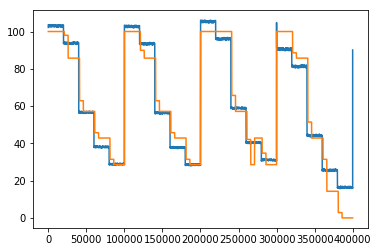

In [138]:
plt.plot(y_lr)
plt.plot(rul)

# Decision Tree Feature Importance

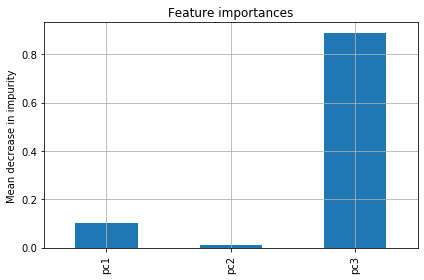

In [81]:
importances = pd.Series(dt_model.featureImportances, index=['pc1','pc2','pc3'])

fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.grid()

# GBT Feature importance

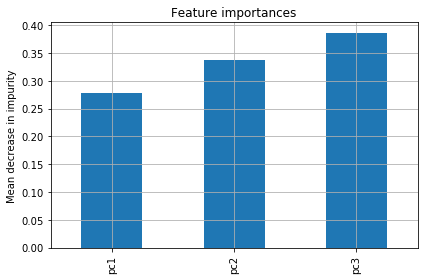

In [61]:
importances = pd.Series(gbt_model.featureImportances,index=['pc1','pc2','pc3'] )

fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.grid()

# Grid search
#### Helps find the optimum parameters to boost the accuracy 

In [24]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder,TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator

In [11]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [5, 10, 15]) \
    .addGrid(lr.regParam, [0.1, 0.3,0.5,0.9]) \
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)  

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(transformedData)

In [27]:
tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

# Run TrainValidationSplit, and choose the best set of parameters.
tvs_model = tvs.fit(transformedData)

#### we see small improvement for the grid search models after using optimum parameters. lrModel corresponds to the orignal model here

In [29]:
cv_pred = cvModel.transform(transformedData)
tvs_pred = tvs_model.transform(transformedData)
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
print("%s R2 on train data = %g" % ('lrModel',evaluator.evaluate(lr_pred)))
print("%s R2 on train data = %g" % ('cvModel',evaluator.evaluate(cv_pred)))
print("%s R2 on train data = %g" % ('tvsModel',evaluator.evaluate(tvs_pred)))

lrModel R2 on train data = 0.942039
cvModel R2 on train data = 0.942247
tvsModel R2 on train data = 0.942247
